# Prophet Workflow Summary
## Data Preparation & Exploration
- Data Preprocessing → Clean & prepare data (handle missing values, outliers, convert ds to datetime)
- Exploratory Data Analysis (EDA) → Understand trends, seasonality, and correlations
- Feature Engineering → Create useful variables (lags, moving averages, categorical encoding)
## Prophet Model Workflow
- Step 1: Create Prophet model instance
- Step 2: Add regressors (holidays, weather, events, etc.)
- Step 3: Fit the model on training data
- Step 4: Extract & interpret regressor coefficients
- Step 5: Performance Metrics → Evaluate using cross-validation (MAE, RMSE, MAPE)
- Step 6: Visualization & Interpretation → Plot forecasts & component analysis
- Step 7: Forecast future values

In [61]:
from prophet import Prophet
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import plot_cross_validation_metric

In [32]:
df = pd.read_csv("../data/preprocessed-data.csv")
holidays = pd.read_csv("../data/holidays.csv")

In [33]:
df['ds'] = pd.to_datetime(df['ds'])
holidays['ds'] = holidays['ds'].astype(str).str.strip()
holidays['ds'] = holidays['ds'].str.split().str[0]  # Keeps only the YYYY-MM-DD part
holidays['ds'] = pd.to_datetime(holidays['ds'], format='%Y-%m-%d', errors='coerce')

In [34]:
holidays.head()


,Unnamed: 0,holiday,ds,lower_window,upper_window
0,16,gen_holi,2011-01-17,-2,2
1,51,gen_holi,2011-02-21,-2,2
2,104,gen_holi,2011-04-15,-2,2
3,149,gen_holi,2011-05-30,-2,2
4,184,gen_holi,2011-07-04,-2,2


In [35]:
m = Prophet(holidays = holidays,
            seasonality_mode="multiplicative",
            seasonality_prior_scale=10, # default value 10
            holidays_prior_scale=10,
            changepoint_prior_scale=0.05)
m.add_regressor("workingday")
m.add_regressor("weathersit")
m.add_regressor("temp")
m.add_regressor("atemp")
m.add_regressor("hum")
m.add_regressor("windspeed")
m.add_regressor("weathersit_2")
m.add_regressor("weathersit_3")
m.fit(df)

10:03:47 - cmdstanpy - INFO - Chain [1] start processing
10:03:48 - cmdstanpy - INFO - Chain [1] done processing


### Column	Meaning
- `regressor`:Name of the external regressor (e.g., temp, humidity, workingday, etc.)
- `regressor_mode`:How the regressor affects the model: additive (directly added to yhat) or multiplicative (scales yhat)
- `center`:Mean value of the regressor (used for normalization)
- `coef_lower`:Lower bound of the coefficient (confidence interval)
- `coef`:Estimated effect of the regressor on the forecast
- `coef_upper`:Upper bound of the coefficient (confidence interval)

#### `Confifdence Interval`
- A Confidence Interval (CI) gives an estimated range of values that the true effect of a regressor is likely to fall within.
- It helps measure uncertainty in predictions.



In [37]:
# Regressor Coefficient
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,workingday,multiplicative,0.000000,0.219575,0.219575,0.219575
1,weathersit,multiplicative,1.385164,-0.267375,-0.267375,-0.267375
2,temp,multiplicative,0.502732,0.418962,0.418962,0.418962
3,atemp,multiplicative,0.480847,0.902075,0.902075,0.902075
4,hum,multiplicative,0.625717,-0.348422,-0.348422,-0.348422
5,windspeed,multiplicative,0.190534,-0.507703,-0.507703,-0.507703
6,weathersit_2,multiplicative,0.000000,0.165715,0.165715,0.165715
7,weathersit_3,multiplicative,0.000000,-0.028772,-0.028772,-0.028772


### Key Takeaways

- People rent more bikes on working days.
- Bad weather (wind, humidity, rain) decreases rentals.
- Higher temperatures encourage more bike usage.
- Wind speed has the strongest negative effect (makes sense, as cycling in strong wind is difficult).

In [44]:
import pandas as pd

def interpret_prophet_coefficients(df):
    if 'regressor' not in df.columns or 'coef' not in df.columns:
        raise ValueError("DataFrame must contain 'regressor' and 'coef' columns.")
    
    print("Interpreting Prophet Model Coefficients\n")
    
    for i, row in df.iterrows():
        regressor = row['regressor']
        coef = row['coef']
        mode = row.get('regressor_mode', 'unknown')  # Handle missing column
        
        impact = "INCREASES" if coef > 0 else "DECREASES"
        effect_size = "strongly" if abs(coef) > 0.5 else "moderately" if abs(coef) > 0.2 else "weakly"
        
        print(f"{i+1} -> {regressor} ({mode} mode) {impact} predictions {effect_size} ({coef:.3f})")

    print("\n Larger absolute values mean stronger influence on forecasts.")

interpret_prophet_coefficients(regressor_coefficients(m))

Interpreting Prophet Model Coefficients

1 -> workingday (multiplicative mode) INCREASES predictions moderately (0.220)
2 -> weathersit (multiplicative mode) DECREASES predictions moderately (-0.267)
3 -> temp (multiplicative mode) INCREASES predictions moderately (0.419)
4 -> atemp (multiplicative mode) INCREASES predictions strongly (0.902)
5 -> hum (multiplicative mode) DECREASES predictions moderately (-0.348)
6 -> windspeed (multiplicative mode) DECREASES predictions strongly (-0.508)
7 -> weathersit_2 (multiplicative mode) INCREASES predictions weakly (0.166)
8 -> weathersit_3 (multiplicative mode) DECREASES predictions weakly (-0.029)

 Larger absolute values mean stronger influence on forecasts.


## Cross Validation

In [51]:
# initial is the length of the initial training period before cross-validation starts. Prophet uses this to train the model before making predictions on the validation set.
df.shape[0] - 180

521

### Column	Meaning
- `ds`:The actual date/time of the forecast
- `yhat`:The predicted value (forecast) by Prophet
- `yhat_lower`:The lower bound of the uncertainty interval (confidence interval)
- `yhat_upper`:The upper bound of the uncertainty interval
- `y`:The actual observed value (ground truth)
- `cutoff`:The last date Prophet used for training before making this prediction

In [ ]:
df_cv = cross_validation(model=m,
                         horizon = '30 days',
                         period='15 days',
                         initial='521 days',
                         parallel='processes')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-20,8564.525885,7836.729310,9321.450320,6211,2012-06-19
1,2012-06-21,9034.098485,8272.584766,9809.179535,5905,2012-06-19
2,2012-06-22,8675.125831,7912.586940,9509.737589,5823,2012-06-19
3,2012-06-23,8295.804598,7434.149525,9035.514575,7458,2012-06-19
4,2012-06-24,8278.648971,7490.907968,9081.562089,6891,2012-06-19


In [ ]:
performance_metrics(df_cv)

In [60]:
rmse = round(performance_metrics(df_cv)['rmse'].mean(),0)
mape = round(performance_metrics(df_cv)['mape'].mean()*100,2)
mae = round(performance_metrics(df_cv)['mae'].mean(),0)
print(f"The RMSE is {rmse}")
print(f"The MAE is {mae}")
print(f"The MAPE is {mape}%")

The RMSE is 1401.0
The MAE is 1114.0
The MAPE is 109.98%


d:\Machine Learning\TimeSeries\timeVenv\lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
d:\Machine Learning\TimeSeries\timeVenv\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


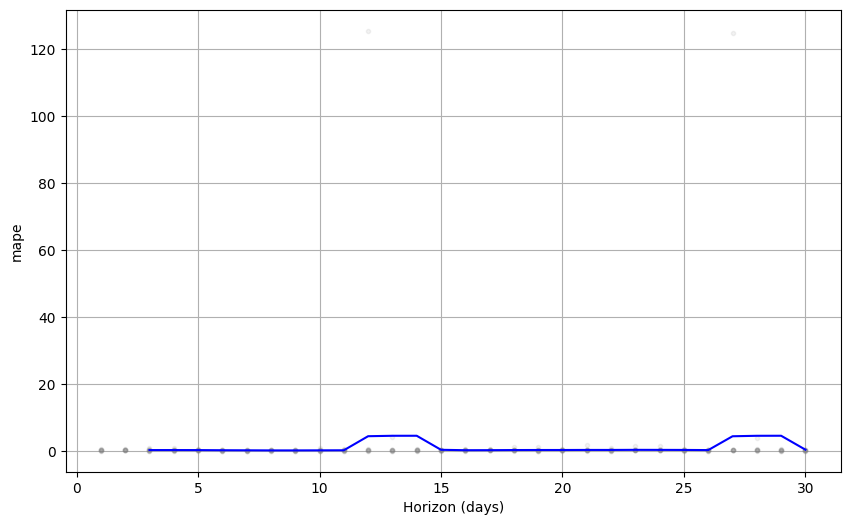

In [63]:
plot_cross_validation_metric(df_cv,metric='mape');